# EEG Data Analysis

For this week's exercise you are going to get a dataset of raw EEG signals and using the Discrete Fourier Transform among other methods you will produce a clean dataset, ready to be classified for the assignment.

The data contains EEG measurements for people who were first asked to keep their eyes open (oa) and then closed (oc). We have split each recording into segments of 30 seconds.

In [44]:
import os
import re
import sys
import mne
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from os.path import join

import pandas as pd
from tqdm.notebook import tqdm

In [46]:
path_data = "data_for_exercise-60000"
data_oa = []
data_oc = []
sample_rate = 500
n_subjects = -1

for folder in tqdm(os.listdir(path_data)[:n_subjects], desc="Loading data"):
    for filename in os.listdir(join(path_data, folder)):
        df = pd.read_csv(join(path_data, folder, filename), sep=",", index_col=0)
        if df.values.shape == (20, int(path_data.split("-")[-1])):
            if "oa" in filename:
                data_oa.append(df.values)
            else:
                data_oc.append(df.values)
        else:
            print(f"Wrong shape for {folder}/{filename}")

Loading data:   0%|          | 0/8 [00:00<?, ?it/s]

In [47]:
print(F"Loaded {len(data_oa)} data segments")

Loaded 15 data segments


Now we want to center all the data around the same value, in eeg data analysis terms this is called referencing. Here we will apply a simple average referencing:

In [48]:
def set_reference(eeg_data, ref_channels):
    """Take the mean of the reference channels and subtract that from the data"""
    ref_signal = np.mean(eeg_data[ref_channels], axis=0)
    re_referenced_data = eeg_data - ref_signal
    return re_referenced_data

In [49]:
[el.shape for el in data_oa]

[(20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000),
 (20, 60000)]

In [50]:
for i in range(len(data_oa)):
    data_oc[i] = set_reference(data_oc[i], np.arange(20))
    data_oa[i] = set_reference(data_oa[i], np.arange(20))

Let's take a look at the data:

In [51]:
def plot_eeg_mne_style(eeg_data, ch_names, sampling_rate):
    """
    Plot EEG data in an MNE-style plot for each channel.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    ch_names : list of str
        List of channel names (must be of length n_channels).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    """    
    # Create MNE info structure with channel names and sampling rate
    info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types='eeg')
    
    # Create MNE RawArray object with the data
    raw = mne.io.RawArray(eeg_data, info)
    
    # Plot the EEG data with MNE's built-in plot function
    raw.plot(scalings='auto', show=True, block=True)
    plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=60000
    Range : 0 ... 59999 =      0.000 ...   119.998 secs
Ready.


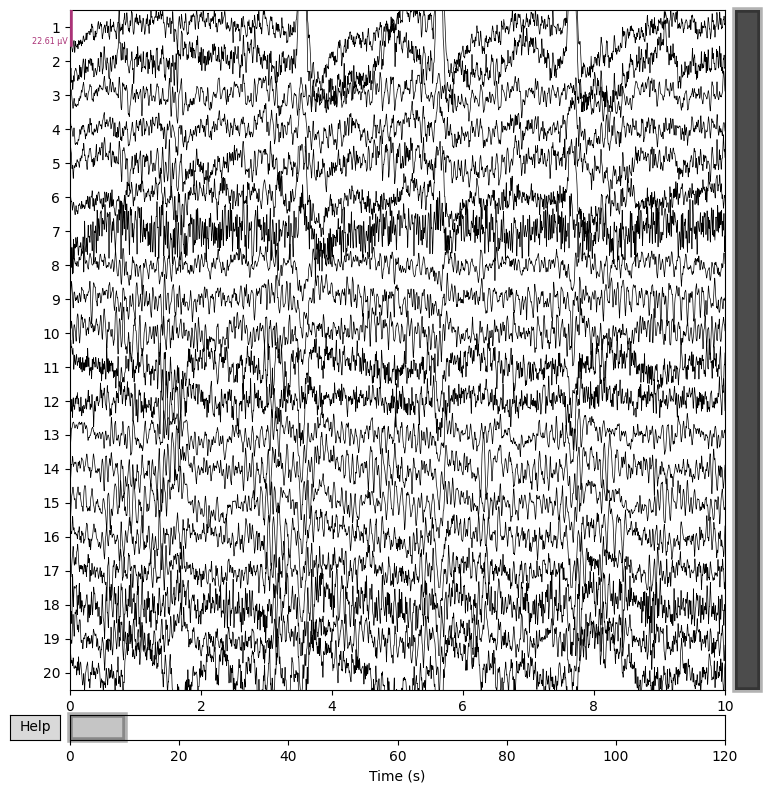

In [52]:
channel_names = np.arange(1,21,1).astype(str).tolist()
plot_eeg_mne_style(data_oa[4], ch_names=channel_names, sampling_rate=sample_rate)

From this there is very little the untrained eye can glean. Try plotting some of the other data to get a feel for whether this noisy plot is representative of the data.

Now we have the data loaded and centered. The next step is to decompose the signals into their frequency components using the DFT. In addition, we will implement masking of the output based on a minimum and maximum frequency. For EEG inspection we were recommended to look at the frequencies between 1-40 Hz.

In [53]:
def compute_power_spectrum(signal, sampling_rate, min_freq=None, max_freq=None):
    """
    Computes the power spectrum for each channel in the signal.

    Parameters:
    signal : np.ndarray
        Input signal with shape (n_channels, n_points)
    sampling_rate : float
        The sampling rate of the signal (in Hz).

    Returns:
    freqs : np.ndarray
        The frequencies corresponding to the power spectrum.
    power_spectrum : np.ndarray
        Power spectrum of each channel with shape (n_channels, n_points//2).
    """
    n_channels, n_points = signal.shape
    
    # Perform the FFT for each channel
    fft_vals = np.fft.rfft(signal, axis=1)
    
    # Compute the power spectrum (squared magnitude of the FFT)
    power_spectrum = np.abs(fft_vals) ** 2
    
    # Compute the corresponding frequencies
    freqs = np.fft.rfftfreq(n_points, 1 / sampling_rate)
    
    if min_freq is not None:
        power_spectrum = power_spectrum[:, freqs >= min_freq]
        freqs = freqs[freqs >= min_freq]

    if max_freq is not None:
        power_spectrum = power_spectrum[:, freqs <= max_freq]
        freqs = freqs[freqs <= max_freq]
    
    return freqs, power_spectrum

In [54]:
def plot_power_spectrum_overlay(freqs, power_spectrum, ch_names, show=False, title=""):
    """
    Plot the power spectrum for all channels on the same plot.

    Parameters:
    eeg_data : np.ndarray
        The EEG data with shape (n_channels, n_points).
    sampling_rate : float
        The sampling rate of the EEG data (in Hz).
    ch_names : list of str
        List of channel names.
    """
    colors = cm.viridis(np.linspace(0, 1, len(ch_names)))

    for i, ch_name in enumerate(ch_names):
        plt.plot(freqs, power_spectrum[i], color=colors[i], label=ch_name)

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.title('Power Spectrum for EEG Channels' if not title else title)
    plt.tight_layout()
    if show:
        plt.show()
    

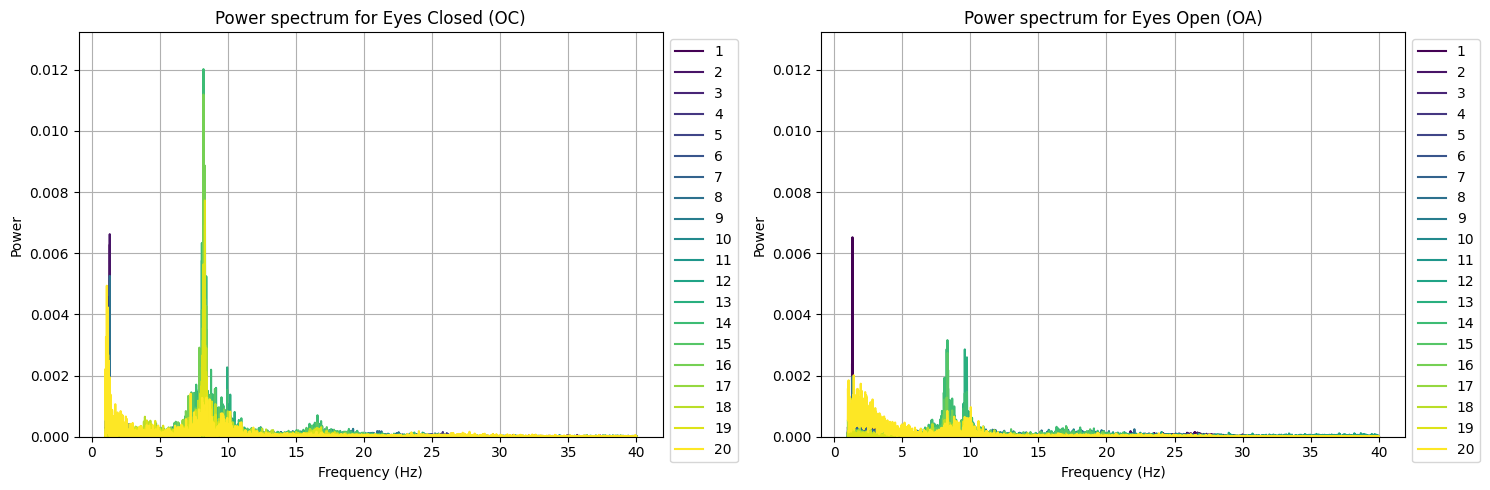

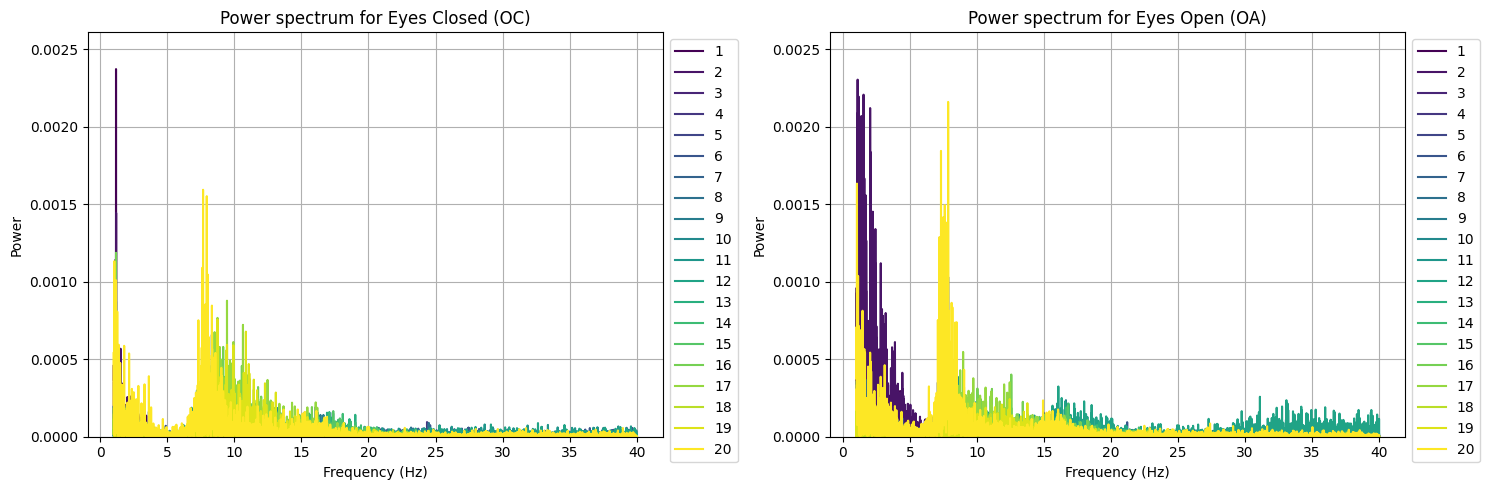

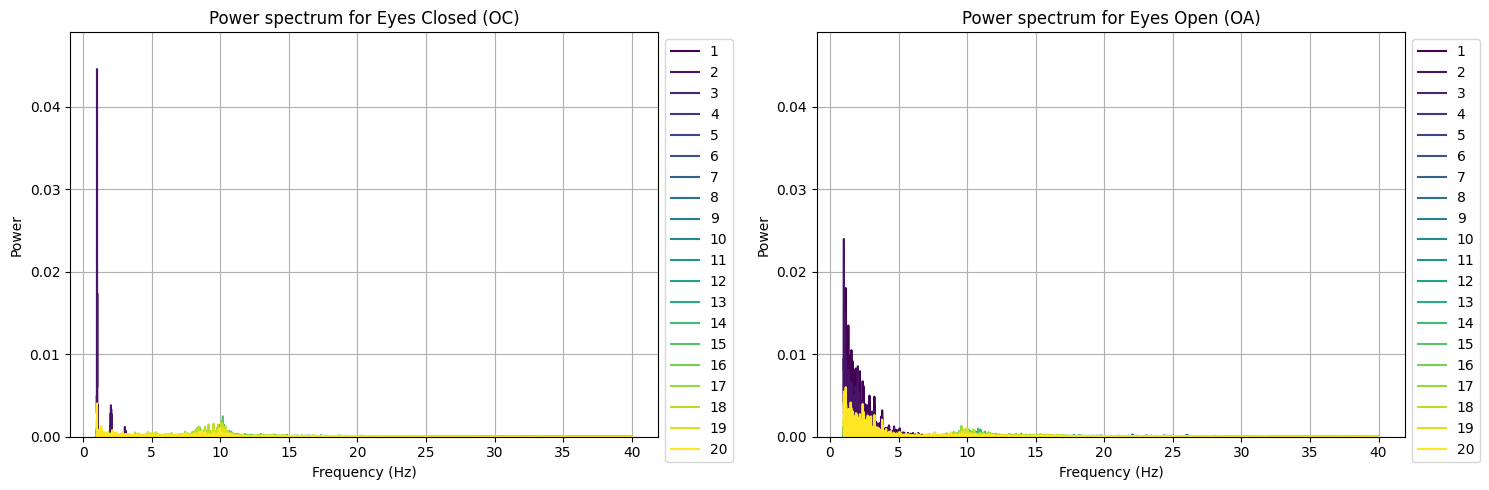

In [85]:
segments_to_plot = [0, 3, 5]
for segment in segments_to_plot:
    plt.subplots(1, 2, figsize=(15, 5))
    
    # Compute power spectra for both conditions
    freqs_oc, power_spectrum_oc = compute_power_spectrum(data_oc[segment], sampling_rate=sample_rate, min_freq=1, max_freq=40)
    freqs_oa, power_spectrum_oa = compute_power_spectrum(data_oa[segment], sampling_rate=sample_rate, min_freq=1, max_freq=40)
    
    # Determine the y-limit based on the maximum value of both power spectra
    y_max = max(power_spectrum_oc.max(), power_spectrum_oa.max())
    
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, power_spectrum_oc, channel_names, title=f"Power spectrum for Eyes Closed (OC)")
    plt.ylim([0, y_max + y_max / 10])
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, power_spectrum_oa, channel_names, title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim([0, y_max + y_max / 10])
    plt.show()

When comparing the eyes closed and eyes open spectrograms, is there a noticeable difference between the two. How could we use this difference for classification? Hints: using energy?  

We will now focus on two channels that we know are strongly correlated to open/closed eyes.

In [77]:
data_oc_optical_channels = [arr[17:19] for arr in data_oc]
data_oa_optical_channels = [arr[17:19] for arr in data_oa]

Now let's get the power spectra from the range that seems to be the most suited for classifying the difference between OC and OA:

In [78]:
min_freq = 1
max_freq = 20
power_spectra_oc = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr in data_oc_optical_channels]
power_spectra_oa = [compute_power_spectrum(arr, sampling_rate=sample_rate, min_freq=min_freq, max_freq=max_freq) for arr
                    in data_oa_optical_channels]

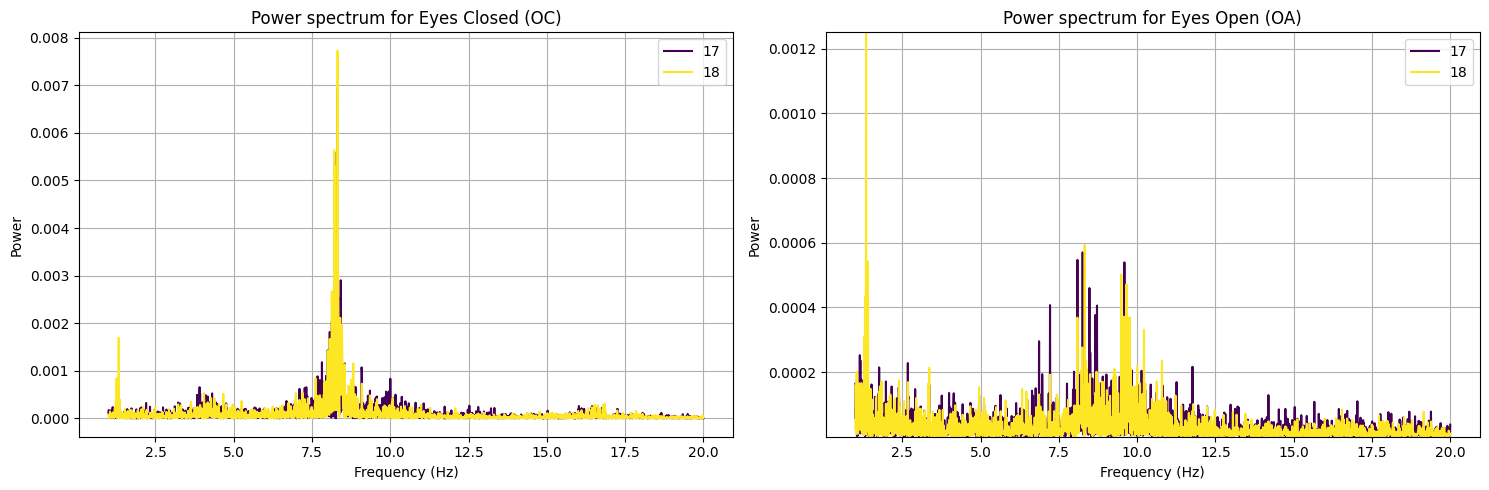

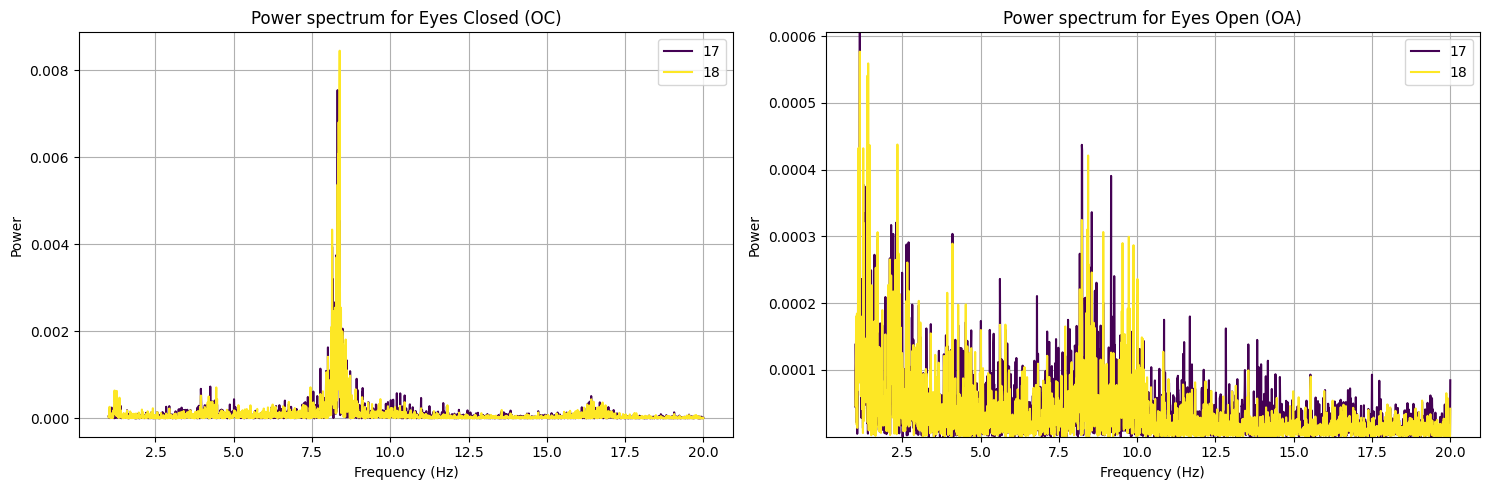

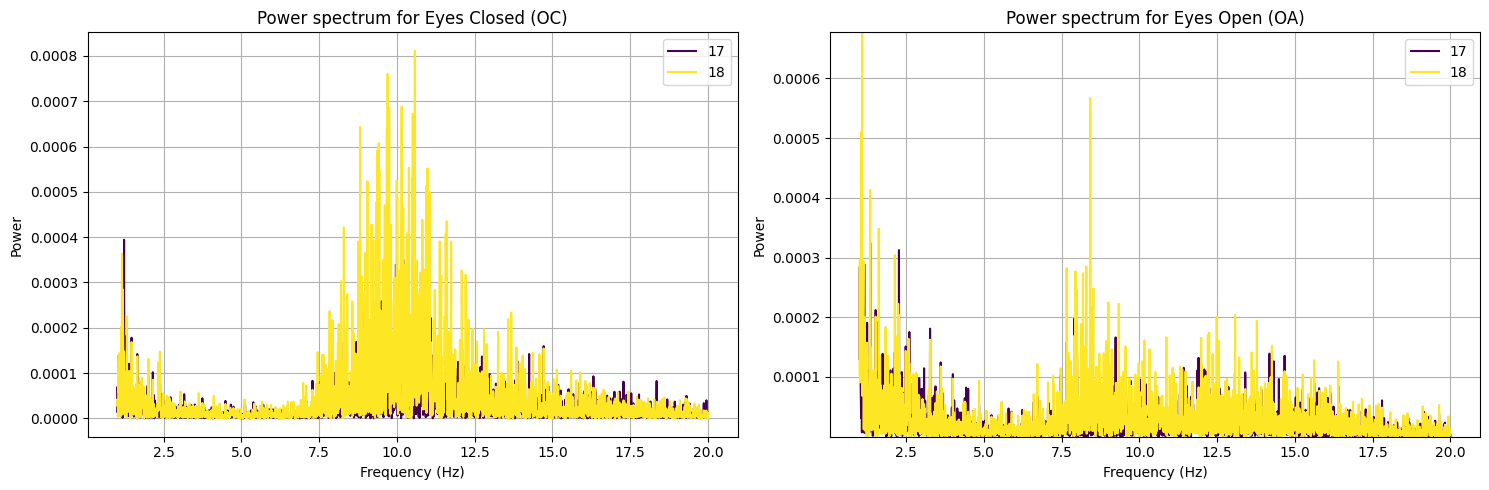

In [79]:
n_plots = 3
for (freqs_oc, spectrum_oc), (freqs_oa, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa[:n_plots]):
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_power_spectrum_overlay(freqs_oc, spectrum_oc, ch_names=[17, 18], title=f"Power spectrum for Eyes Closed (OC)")
    plt.subplot(1, 2, 2)
    plot_power_spectrum_overlay(freqs_oa, spectrum_oa, ch_names=[17, 18], title=f"Power spectrum for Eyes Open (OA)")
    plt.ylim(spectrum_oc.min(), spectrum_oa.max())
    plt.show()

Now let's compute the sum of the energies in this range and plot them

In [80]:
alphas_oc = []
alphas_oa = []
for (freqs_oc, spectrum_oc), (freqs_oa, spectrum_oa) in zip(power_spectra_oc, power_spectra_oa):
    alpha_oc = np.sum(spectrum_oc)
    alpha_oa = np.sum(spectrum_oa)
    
    alphas_oc.append(alpha_oc)
    alphas_oa.append(alpha_oa)
alphas_oc = np.array(alphas_oc)
alphas_oa = np.array(alphas_oa)

In [81]:
def plot_alphas(alphas_oc, alphas_oa, show=False, s = 10):
    fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.scatter(range(len(alphas_oc)), alphas_oc, label='OC', color='blue', s=s) 
    plt.scatter(range(len(alphas_oa)), alphas_oa, label='OA', color='orange', s=s)
    plt.hlines(3.0 * 1e-6, 0, len(alphas_oc), linestyles='dashed', color='red')
    plt.title('OA and OC energy of alpha frequencies compared')
    plt.xlabel('Subject')
    plt.ylabel('Amplitude')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.scatter(range(len(alphas_oc)), alphas_oc / alphas_oa, label='Ratio', color='red', s=s)
    plt.hlines(1, 0, len(alphas_oc), linestyles='dashed', color='red')
    plt.xlabel('Subject')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()

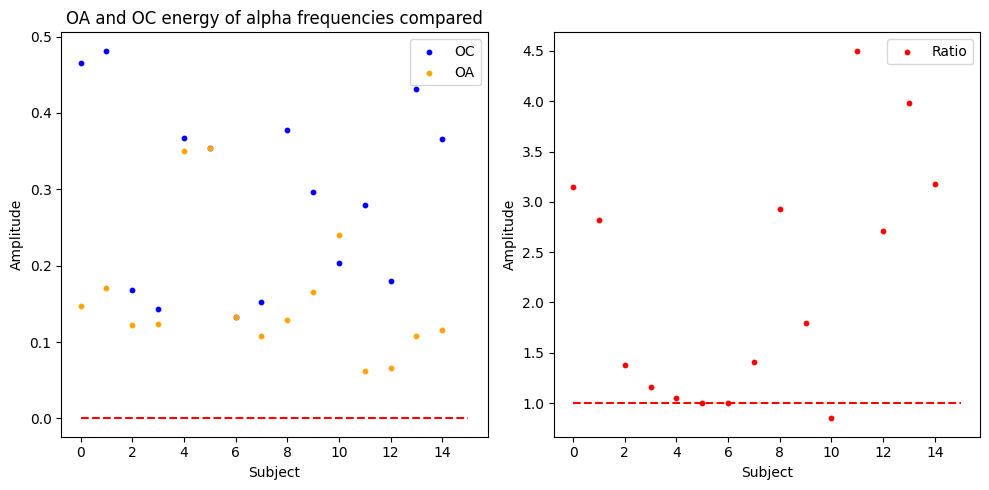

In [82]:
plot_alphas(alphas_oc, alphas_oa, show=True)

A simple classifier would be applying a threshold to the 

Try the above classification only including 